# Segmentation

Segmentation is **the process of partitioning a pointcloud into multiple segments or regions**.

In a typical reverse-engineering or reconstruction process, regions are usually replaced by analytic surfaces in a later step.


In [1]:
# Necessary imports
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt


For the sake of illustration, let's consider a pointcloud sampling a regular tetrahedron. Also called a triangular pyramid, a tetrahedron composed of four triangular faces. As a result, the pointcloud is expected to be segmented into four regions.

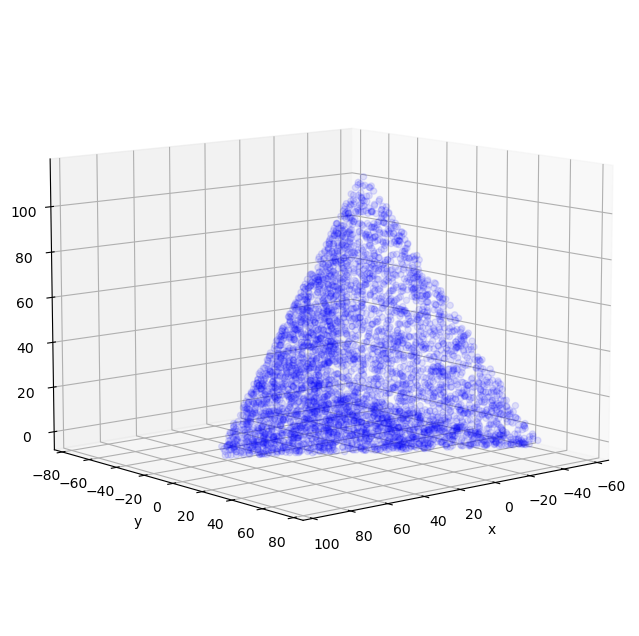

In [2]:
data = np.loadtxt("./data/tetrahedron.xyz")
points, normals = data[:, :3], data[:, 3:]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          color="blue", alpha=0.1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 50)
plt.axis("equal")
plt.show()


## Region growing

The region growing algorithm is one of the most commonly used algorithms for segmentation, whether for images, pointclouds or meshes. It works by **iteratively aggregating points based on criteria of proximity and homogeneity**, in a bottom-up fashion.

This algorithm is fairly simple, with just two main steps:
1. Creation of a region by the selection of a starting element (or *seed*).
2. Growth of this region by incorporating similar elements from its neighborhood.

The growth phase stops when the elements in the region's neighborhood can no longer be incorporated.

Note that the algorithm requires the prior definition of **a predicate**, measuring the degree of similarity of a given element with the growing region. Numerous indicators may be used to assess similarity, alone or in combination, such as normals, colors, local curvature, etc. Similarly, the notion of neighborhood may take various definitions, such as spherical neighborhood, planar neighborhood, etc.

In the example below, normals are used to assess similarity (if the angular difference is less than a threshold, then the candidate point is integrated into the region; otherwise, it is rejected) and spherical neighborhoods are used to assess proximity.


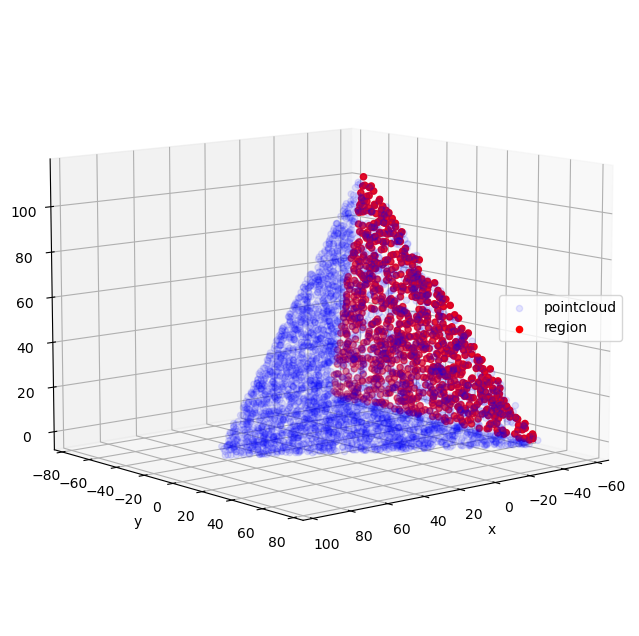

In [3]:
def similarity_criterion(n_p, n_q, alpha):
    """Check if the angle between normals n_p and n_q is under alpha."""

    inner = (n_p @ n_q).clip(-1., 1.) # arccos only takes values in  [-1., 1.]
    angle = np.arccos(inner) * 180/np.pi # in degrees
    
    return True if angle < alpha else False


def region_growing(points, normals, radius, threshold, seed=None):

    # Spatial indexing
    kdtree = KDTree(points)

    # Queue
    if seed is None:
        seed = np.random.choice(len(points))
    queue = np.array([seed], dtype=int)

    # List of already visited points
    visited = np.zeros(len(points), dtype=bool)
    visited[seed] = True

    # Instanciate a region containing the seed
    region = np.copy(queue)

    # Search as long as queue is not empty
    while len(queue):
        # Extract one point of queue
        q = queue[0]
        queue = np.delete(queue, 0)
        # Find its neighbors
        neighbors = kdtree.query_ball_point(points[q], radius)
        # For each neighbors p
        for p in neighbors:
            if not visited[p] and similarity_criterion(normals[p], normals[q], threshold):
                # Add p to the region R
                region = np.append(region, p)
                visited[p] = True
                # Add p to queue
                queue = np.append(queue, p)

    return region


# Try
region = region_growing(points, normals, 10., 10., seed=42)
segmented_points = points[region]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
          color="blue", alpha=0.1, label="pointcloud")
ax.scatter(segmented_points[:, 0], segmented_points[:, 1], segmented_points[:, 2],
          color="red", label="region")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 50)
plt.axis("equal")
plt.show()   
    

The algorithm is usually repeated until every point of the pointcloud has been assigned to a region ($n$ repetitions resulting in $n$ regions).

4 regions found (expected 4 regions)


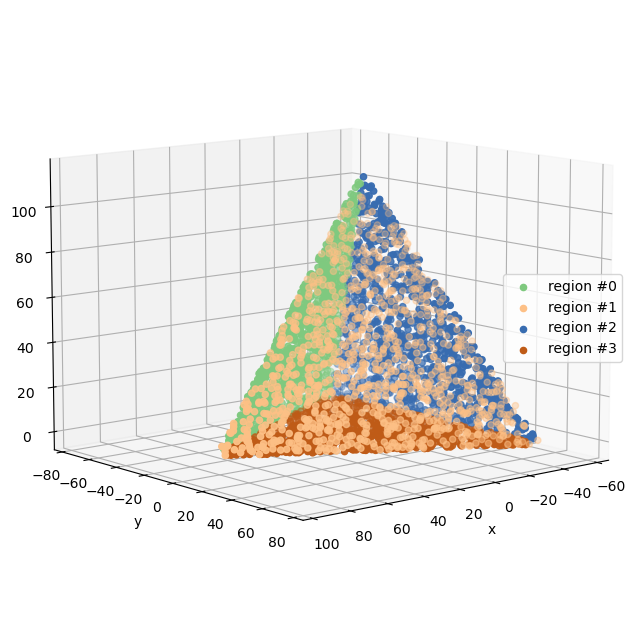

In [4]:
# Try
all_regions = []
remaining_inds = np.arange(len(points), dtype=int)

while len(remaining_inds):
    region = region_growing(points[remaining_inds], normals[remaining_inds], 10., 10.)
    all_regions.append(remaining_inds[region])
    
    remaining_inds = np.setdiff1d(remaining_inds, remaining_inds[region])

print(len(all_regions), "regions found (expected 4 regions)")

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
cmap = plt.get_cmap(name="Accent", lut=len(all_regions)+1)
for i, region in enumerate(all_regions):
    ax.scatter(points[region, 0], points[region, 1], points[region, 2],
              color=cmap(i), label=f"region #{i}")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 50)
plt.axis("equal")
plt.show()


The region-growth algorithm is relatively simple to conceptualize and implement. However, its results depend on the a priori definition of a suitable predicate. Its parameters (thresholds used to define the notion of similarity) need to be adjusted according to the context (pointcloud density, presence of noise, etc.).

## RANSAC

The Random sample consensus (RANSAC) algorithm aims to estimate the parameters of *model* from a dataset that contains outliers.

Fischler, M. A., & Bolles, R. C. (1981). Random sample consensus: a paradigm for model fitting with applications to image analysis and automated cartography. *Communications of the ACM*, 24(6), 381-395.


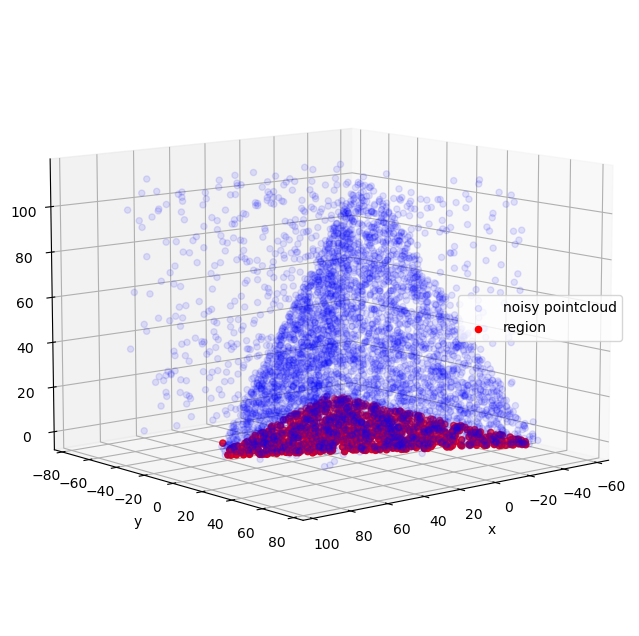

In [5]:
def compute_plane(points):

    v1, v2 = points[1, :] - points[0, :], points[2, :] - points[0, :]
    normal = np.cross(v1, v2) / np.linalg.norm(np.cross(v1, v2))

    return points[0, :], normal

def in_plane(points, center, normal, threshold):

    dists = np.abs((points - center) @ normal)

    return np.nonzero(dists < threshold)[0]

def RANSAC_plane(points, n_draws, threshold):

    best_score = 0
    best_center, best_normal = None, None
    best_inliers = None

    for _ in range(n_draws):
        # Random sampling
        min_sample_size = 3
        sampled_inds = np.random.choice(len(points), size=min_sample_size, replace=False)
        sampled_points = points[sampled_inds]
        # Candidate plane
        candidate_center, candidate_normal = compute_plane(sampled_points)
        # Inliers
        candidate_inliers = in_plane(points, candidate_center, candidate_normal, threshold)
        # Score
        score = len(candidate_inliers)
        # Keep best candidate
        if score > best_score:
            best_score = score
            best_center, best_normal = candidate_center, candidate_normal
            best_inliers = candidate_inliers

    return best_center, best_normal, best_score, best_inliers
            
# Try
outliers = np.random.uniform(points.min(axis=0), points.max(axis=0), (1000, 3))
points_with_outliers = np.vstack([points, outliers])

best_center, best_normal, best_score, best_inliers = RANSAC_plane(points_with_outliers, 100, .1)
segmented_points = points_with_outliers[best_inliers]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(points_with_outliers[:, 0], points_with_outliers[:, 1], points_with_outliers[:, 2],
          color="blue", alpha=0.1, label="noisy pointcloud")
ax.scatter(segmented_points[:, 0], segmented_points[:, 1], segmented_points[:, 2],
          color="red", label="region")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 50)
plt.axis("equal")
plt.show()  
    

As before, the algorithm is usually repeated until every point of the pointcloud has been assigned to a region ($n$ repetitions resulting in $n$ regions).

4 regions found (expected 4 regions)


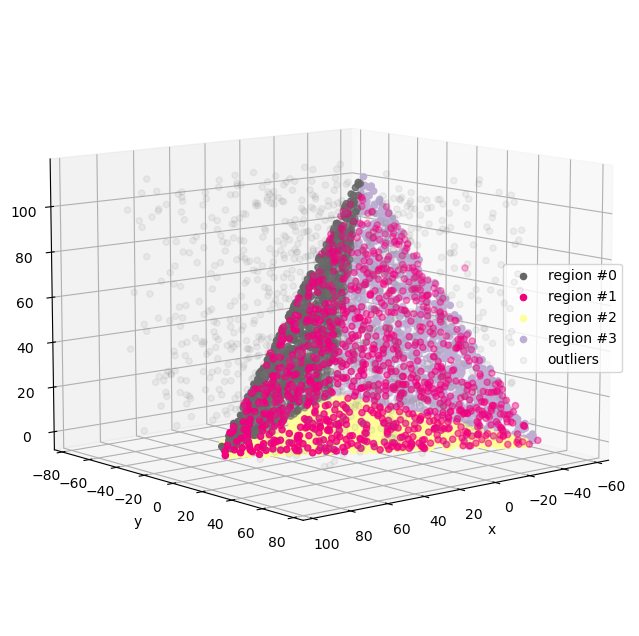

In [6]:
# Try
max_number_of_runs = 10
min_points_per_region = 100

all_regions = []
remaining_inds = np.arange(len(points_with_outliers), dtype=int)

for _ in range(max_number_of_runs):
    _, _, _, region = RANSAC_plane(points_with_outliers[remaining_inds], 100, .1)

    if len(region) > min_points_per_region:
        all_regions.append(remaining_inds[region])
        remaining_inds = np.setdiff1d(remaining_inds, remaining_inds[region])

print(len(all_regions), "regions found (expected 4 regions)")

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
cmap = plt.get_cmap(name="Accent_r", lut=len(all_regions)+1)
for i, region in enumerate(all_regions):
    ax.scatter(points_with_outliers[region, 0], points_with_outliers[region, 1], points_with_outliers[region, 2],
              color=cmap(i), label=f"region #{i}")

ax.scatter(points_with_outliers[remaining_inds, 0], points_with_outliers[remaining_inds, 1], points_with_outliers[remaining_inds, 2],
              color="grey", alpha=0.1, label="outliers")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 50)
plt.axis("equal")
plt.show()

The algorithm has been improved since.

Schnabel, R., Wahl, R., & Klein, R. (2007, June). Efficient RANSAC for point‐cloud shape detection. In *Computer graphics forum* (Vol. 26, No. 2, pp. 214-226). Oxford, UK: Blackwell Publishing Ltd.